# Imports

In [1]:
import torch
import torch.nn as nn  # All neural network modules, nn.linear, nn.conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that have no parameters
import torch.utils.data as DataLoader # Gives easier datasetmanagement and creates mini batches
import torchvision.datasets as datasets # Has Standard datasets we can import 
import torchvision.transforms as transforms # transformations we can perform on our dataset
import time
import random
import torchvision


## Arguments
import argparse



In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# VGG-16 MODEL

#### VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
#### Then flatten and 4096 x 4096 x 1000 linear layers

In [3]:
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

decode_VGG_types = {
    'VGG11' : [512, 256, 128, 64],
    'VGG13' : [512, 256, 128, 64],
    'VGG16' : ['U', 512, 512, 512, 'U', 512, 512, 512, 'U', 256, 256, 256, 'U', 128, 128, 'U', 64, 64], #'VGG16' : [512, 256, 128, 64],
    'VGG19' : [512, 256, 128, 64]
}

In [4]:
import torchvision.models as models

# ** with the help of "https://github.com/say4n/pytorch-segnet/blob/master/src/model.py"
class VGG_net_youtube_new(nn.Module):
    
    def __init__(self, in_channels=3, out_channels = 49):
        super(VGG_net_youtube_new, self).__init__()
        
        # assign the in and out channels of the vgg model
        self.input_channels = in_channels
        self.output_channels = out_channels
        
        # ** use the pretrained vgg16 model from pytorch
        self.vgg16 = models.vgg16(pretrained=True)
        
        
        #################### ENCODING ####################
        # first ENCODING layer
        self.conv1_1 = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                 out_channels=64,
                                 kernel_size=(3,3), 
                                 stride=(1,1),
                                 padding=(1,1)),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
        
        
        self.conv1_2 = nn.Sequential(nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
                
        self.max1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # second ENCODING layer
        self.conv2_1 = nn.Sequential(nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU())
        
        self.conv2_2 = nn.Sequential(nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU())
        
        self.max2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # third ENCODING layer
        self.conv3_1 = nn.Sequential(nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
        
        self.conv3_2 = nn.Sequential(nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
        
        self.conv3_3 = nn.Sequential(nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
                
        self.max3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # forth ENCODING layer
        self.conv4_1 = nn.Sequential(nn.Conv2d(in_channels=256,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv4_2 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv4_3 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
                
        self.max4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
         # fifth ENCODING layer
        self.conv5_1 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv5_2 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv5_3 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
                
        self.max5 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # **
        self.init_vgg_weigts()
        
        #################### DECODING ####################
        # first DECODING layer
        self.deconv1_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv1_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv1_3 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
                
        #self.upsample1 = nn.Upsample(scale_factor=(2, 2), mode="bilinear", align_corners=False)
        
        # second DECODING layer
        self.deconv2_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv2_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv2_3 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
                
        #self.upsample2 = nn.Upsample(scale_factor=(2, 2), mode="bilinear", align_corners=False)
        
        # third DECODING layer
        self.deconv3_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.deconv3_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.deconv3_3 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
                
        #self.upsample3 = nn.Upsample(scale_factor=(2, 2), mode="bilinear", align_corners=False)
        
        # forth DECODING layer
        self.deconv4_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=128,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        
        self.deconv4_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
                
        #self.upsample4 = nn.Upsample(scale_factor=(2, 2), mode="bilinear", align_corners=False)
        
         # fifth DECODING layer
        self.deconv5_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
        self.deconv5_2 = nn.ConvTranspose2d(in_channels=64,
                               out_channels= out_channels,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1))
                
        #self.upsample5 = nn.Upsample(scale_factor=(2, 2), mode="bilinear", align_corners=False)
        
        
    def forward(self, x):
        
        #print(x.size())
        dim_0 = x.size() 
        x = self.conv1_1(x) #nn.Sequential(self.conv1_1(x), nn.ReLU())
        x = self.conv1_2(x)
        #print("OKKKK")
        x, ind_0 = self.max1(x)
        f1 = x
        
        dim_1 = x.size()
        x = self.conv2_1(x)
        x = self.conv2_2(x) #nn.Sequential(self.conv2_2(x), nn.ReLU())
        x, ind_1 = self.max2(x)
        f2 = x
        
        dim_2 = x.size()
        x = self.conv3_1(x)#nn.Sequential(self.conv3_1(x), nn.ReLU())
        x = self.conv3_2(x)#nn.Sequential(self.conv3_2(x), nn.ReLU())
        x = self.conv3_3(x)#nn.Sequential(self.conv3_3(x), nn.ReLU())
        x, ind_2 = self.max3(x)
        f3 = x
        
        dim_3 = x.size()
        x = self.conv4_1(x) #nn.Sequential(self.conv4_1(x), nn.ReLU())
        x = self.conv4_2(x) #nn.Sequential(self.conv4_2(x), nn.ReLU())
        x = self.conv4_3(x) #nn.Sequential(self.conv4_3(x), nn.ReLU())
        x, ind_3 = self.max4(x)
        f4 = x
        
        dim_4 = x.size()
        x = self.conv5_1(x)#nn.Sequential(self.conv5_1(x), nn.ReLU())
        x = self.conv5_2(x)#nn.Sequential(self.conv5_2(x), nn.ReLU())
        x = self.conv5_3(x)#nn.Sequential(self.conv5_3(x), nn.ReLU())
        x, ind_4 = self.max5(x)
        f5 = x
        
        ## may be do some flattening here
        ##???????????
        
        dim_dec = x.size()
        #x = self.upsample1(x)
        #x = torch.cat((f5, x), dim=2)
        #x = f5 + x
        x = F.max_unpool2d(x, ind_4, kernel_size=(2,2), stride=(2,2), output_size=dim_4)
        x = self.deconv1_1(x) #nn.Sequential(self.deconv1_1(x), nn.ReLU())
        x = self.deconv1_2(x)#nn.Sequential(self.deconv1_2(x), nn.ReLU())
        x = self.deconv1_3(x)#nn.Sequential(self.deconv1_3(x), nn.ReLU())
        dim_d4 = x.size()

        #x = self.upsample2(x)
        #x = torch.cat((f4, x), dim=2)
        #x = f4 + x

        x = F.max_unpool2d(x, ind_3, kernel_size=(2,2), stride=(2,2), output_size=dim_3)
        x = self.deconv2_1(x)#nn.Sequential(self.deconv2_1(x), nn.ReLU())
        x = self.deconv2_2(x)#nn.Sequential(self.deconv2_2(x), nn.ReLU())
        x = self.deconv2_3(x)#nn.Sequential(self.deconv2_3(x), nn.ReLU())
        dim_d3 = x.size()
        
        #x = self.upsample3(x)
        #x = torch.cat((f3, x), dim=2)
        #x = f3 + x
        x = F.max_unpool2d(x, ind_2, kernel_size=(2,2), stride=(2,2), output_size=dim_2)
        x = self.deconv3_1(x) #nn.Sequential(self.deconv3_1(x), nn.ReLU())
        x = self.deconv3_2(x) #nn.Sequential(self.deconv3_2(x), nn.ReLU())
        x = self.deconv3_3(x) #nn.Sequential(self.deconv3_3(x), nn.ReLU())
        dim_d2 = x.size()
        
        #x = self.upsample4(x)
        #x = torch.cat((f2, x), dim=2)
        #x = f2 + x
        x = F.max_unpool2d(x, ind_1, kernel_size=(2,2), stride=(2,2), output_size=dim_1)
        x = self.deconv4_1(x) #nn.Sequential(self.deconv4_1(x), nn.ReLU())
        x = self.deconv4_2(x) #nn.Sequential(self.deconv4_2(x), nn.ReLU())
        dim_d1 = x.size()
        
        #x = self.upsample5(x)
        #x = torch.cat((f1, x), dim=2)
        #x = f1 + x
        x = F.max_unpool2d(x, ind_0, kernel_size=(2,2), stride=(2,2), output_size=dim_0)
        x = self.deconv5_1(x) #nn.Sequential(self.deconv5_1(x), nn.ReLU())
        x = self.deconv5_2(x) #nn.Sequential(self.deconv5_2(x), nn.ReLU())
        #print("x.shape ===== ", x.shape)
        dim_d0 = x.size()
            
        
        # last layer
        soft_max = F.softmax(x, dim=1) 
        #soft_max = nn.Softmax(x)
        
        # softmax
        #output = nn.Softmax(x)
        
        return x, soft_max    # 1st way return , soft_maxx
    
    
    
    # **
    def init_vgg_weigts(self):
        assert self.conv1_1[0].weight.size() == self.vgg16.features[0].weight.size()
        self.conv1_1[0].weight.data = self.vgg16.features[0].weight.data
        assert self.conv1_1[0].bias.size() == self.vgg16.features[0].bias.size()
        self.conv1_1[0].bias.data = self.vgg16.features[0].bias.data

        assert self.conv1_2[0].weight.size() == self.vgg16.features[2].weight.size()
        self.conv1_2[0].weight.data = self.vgg16.features[2].weight.data
        assert self.conv1_2[0].bias.size() == self.vgg16.features[2].bias.size()
        self.conv1_2[0].bias.data = self.vgg16.features[2].bias.data

        assert self.conv2_1[0].weight.size() == self.vgg16.features[5].weight.size()
        self.conv2_1[0].weight.data = self.vgg16.features[5].weight.data
        assert self.conv2_1[0].bias.size() == self.vgg16.features[5].bias.size()
        self.conv2_1[0].bias.data = self.vgg16.features[5].bias.data

        assert self.conv2_2[0].weight.size() == self.vgg16.features[7].weight.size()
        self.conv2_2[0].weight.data = self.vgg16.features[7].weight.data
        assert self.conv2_2[0].bias.size() == self.vgg16.features[7].bias.size()
        self.conv2_2[0].bias.data = self.vgg16.features[7].bias.data

        assert self.conv3_1[0].weight.size() == self.vgg16.features[10].weight.size()
        self.conv3_1[0].weight.data = self.vgg16.features[10].weight.data
        assert self.conv3_1[0].bias.size() == self.vgg16.features[10].bias.size()
        self.conv3_1[0].bias.data = self.vgg16.features[10].bias.data

        assert self.conv3_2[0].weight.size() == self.vgg16.features[12].weight.size()
        self.conv3_2[0].weight.data = self.vgg16.features[12].weight.data
        assert self.conv3_2[0].bias.size() == self.vgg16.features[12].bias.size()
        self.conv3_2[0].bias.data = self.vgg16.features[12].bias.data

        assert self.conv3_3[0].weight.size() == self.vgg16.features[14].weight.size()
        self.conv3_3[0].weight.data = self.vgg16.features[14].weight.data
        assert self.conv3_3[0].bias.size() == self.vgg16.features[14].bias.size()
        self.conv3_3[0].bias.data = self.vgg16.features[14].bias.data

        assert self.conv4_1[0].weight.size() == self.vgg16.features[17].weight.size()
        self.conv4_1[0].weight.data = self.vgg16.features[17].weight.data
        assert self.conv4_1[0].bias.size() == self.vgg16.features[17].bias.size()
        self.conv4_1[0].bias.data = self.vgg16.features[17].bias.data

        assert self.conv4_2[0].weight.size() == self.vgg16.features[19].weight.size()
        self.conv4_2[0].weight.data = self.vgg16.features[19].weight.data
        assert self.conv4_2[0].bias.size() == self.vgg16.features[19].bias.size()
        self.conv4_2[0].bias.data = self.vgg16.features[19].bias.data

        assert self.conv4_3[0].weight.size() == self.vgg16.features[21].weight.size()
        self.conv4_3[0].weight.data = self.vgg16.features[21].weight.data
        assert self.conv4_3[0].bias.size() == self.vgg16.features[21].bias.size()
        self.conv4_3[0].bias.data = self.vgg16.features[21].bias.data

        assert self.conv5_1[0].weight.size() == self.vgg16.features[24].weight.size()
        self.conv5_1[0].weight.data = self.vgg16.features[24].weight.data
        assert self.conv5_1[0].bias.size() == self.vgg16.features[24].bias.size()
        self.conv5_1[0].bias.data = self.vgg16.features[24].bias.data

        assert self.conv5_2[0].weight.size() == self.vgg16.features[26].weight.size()
        self.conv5_2[0].weight.data = self.vgg16.features[26].weight.data
        assert self.conv5_2[0].bias.size() == self.vgg16.features[26].bias.size()
        self.conv5_2[0].bias.data = self.vgg16.features[26].bias.data

        assert self.conv5_3[0].weight.size() == self.vgg16.features[28].weight.size()
        self.conv5_3[0].weight.data = self.vgg16.features[28].weight.data
        assert self.conv5_3[0].bias.size() == self.vgg16.features[28].bias.size()
        self.conv5_3[0].bias.data = self.vgg16.features[28].bias.data
    
    

In [5]:
from torchsummary import summary

model = VGG_net_youtube_new(in_channels=3, out_channels=49)
x = torch.randn(1, 3, 226, 226)
summary(model, (3, 226, 226))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 226, 226]           1,792
       BatchNorm2d-2         [-1, 64, 226, 226]             128
              ReLU-3         [-1, 64, 226, 226]               0
            Conv2d-4         [-1, 64, 226, 226]          36,928
       BatchNorm2d-5         [-1, 64, 226, 226]             128
              ReLU-6         [-1, 64, 226, 226]               0
         MaxPool2d-7  [[-1, 64, 113, 113], [-1, 64, 113, 113]]               0
            Conv2d-8        [-1, 128, 113, 113]          73,856
       BatchNorm2d-9        [-1, 128, 113, 113]             256
             ReLU-10        [-1, 128, 113, 113]               0
           Conv2d-11        [-1, 128, 113, 113]         147,584
      BatchNorm2d-12        [-1, 128, 113, 113]             256
             ReLU-13        [-1, 128, 113, 113]               0
        MaxPool2d-14  [

# LoadBaches

In [6]:
import numpy as np
import cv2
import glob
import itertools
from matplotlib import pyplot as plt

class LoadBatches:
    
    
        
    def getImageArr(self, path, width, height, imgNorm="sub_mean", odering='channels_first'):
        try:
            img = cv2.imread(path, 1)

            if imgNorm == "sub_and_divide":
                img = np.float64(cv2.resize(img, (width, height))) / 127.5 - 1
            elif imgNorm == "sub_mean":
                img = cv2.resize(img, (width, height))
                img = img.astype(np.float64)
                img[:, :, 0] -= 103.939
                img[:, :, 1] -= 116.779
                img[:, :, 2] -= 123.68
            elif imgNorm == "divide":
                img = cv2.resize(img, (width, height))
                img = img.astype(np.float64)
                img = img / 255.0
            elif imgNorm == "no":
                img = cv2.resize(img, (width, height))
                img = img.astype(np.float32)


            if odering == 'channels_first':
                img = np.rollaxis(img, 2, 0)
            return img
        except Exception as e:
            print (path, e)
            img = np.zeros((height, width, 3))
            if odering == 'channels_first':
                img = np.rollaxis(img, 2, 0)
            return img


    def getSegmentationArr(self, path, nClasses, width, height):
        #seg_labels = np.zeros((height, width, nClasses))
        seg_labels = np.zeros((nClasses, height, width))
        try:
            img = cv2.imread(path, 1)
            img = cv2.resize(img[:, :, 0], (width, height), interpolation=cv2.INTER_NEAREST)
            #img = img[:, :, 0]
            #img_0 = np.repeat(img[:, :, np.newaxis], 3, axis=2)

            for c in range(nClasses):
                seg_labels[c, :, :] = (img == c).astype(int)

        except Exception as e:
            print (e)

        #print("mask shape ================== ", seg_labels.shape)
        #seg_labels = np.reshape(seg_labels, (nClasses, width , height))
        return seg_labels




    def imageSegmentationGenerator(self, images_path, segs_path, batch_size, n_classes, input_height, input_width, output_height,
                                   output_width):
        
        assert images_path[-1] == '/', images_path
        assert segs_path[-1] == '/', segs_path
        images = glob.glob(images_path + "*.jpg") +  glob.glob(images_path + '*.png') + glob.glob(images_path + "*.jpeg")
        images.sort()
        segmentations = glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg")
        segmentations.sort()

        # print('length of images:',len(images))
        # print('length of segmentations:',len(segmentations))


        assert len(images) == len(segmentations)
        i = 0
        for im, seg in zip(images, segmentations):
            i += 1
            #print('i ======== ', i)
            assert (im.split('/')[-1].split(".")[0] == seg.split('/')[-1].split(".")[0])
            #assert (im.split('/')[-1].split(".")[0].split("_")[:-1] == seg.split('/')[-1].split(".")[0].split("_")[:-1])


            # image_w = cv2.imread(im)
            # mask_w = cv2.imread(seg)


            # plt.figure(figsize=(10, 10))

            # plt.subplot(241)
            # plt.axis('off')
            # plt.imshow(image_w, cmap='jet')
            # plt.title("Original val image") 

            # plt.subplot(245)
            # plt.axis('off')
            # plt.imshow(mask_w, cmap='jet')
            # plt.title("mask val image")   

       
        return images, segmentations


        # MARYAM CODE
        # zipped = itertools.cycle(zip(images, segmentations))
        # zipped_list = list(zip(images, segmentations))
        
        # X = []
        # Y = []
        
        # for zp in zipped_list:
        #     #if zipped_list.index(zp) < int(1170): # kernel dies more than that in local
        #     im, seg = zp
        #     imgNorm = 'sub_mean'
        #     X.append(self.getImageArr(im, input_width, input_height, imgNorm))  # append the image data into the X list
        #     Y.append(self.getSegmentationArr(seg, n_classes, output_width, output_height)) # append the relative mask data into the Y list

        # return(np.array(X), np.array(Y))


        # ABEL CODE
        # while True:
        #     X = []
        #     Y = []
        #     for _ in range(batch_size):
        #         # image and segmented label mask paths
        #         im, seg = next(zipped)
        #         imgNorm = 'sub_mean'
        #         print(input_height)
        #         X.append(self.getImageArr(im, input_width, input_height, imgNorm))  # append the image data into the X list
        #         Y.append(self.getSegmentationArr(seg, n_classes, output_width, output_height)) # append the relative mask data into the Y list
                
        #     yield np.array(X), np.array(Y)


# ARGUMENTS

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument("--save_weights_path", type=str)
parser.add_argument("--train_images", type=str)
parser.add_argument("--train_labels", type=str)
parser.add_argument("--save_dir", type=str)
parser.add_argument("--n_classes", type=int)
parser.add_argument("--input_height", type=int, default=224)
parser.add_argument("--input_width", type=int, default=224)

parser.add_argument('--validate', action='store_false')
parser.add_argument("--val_images", type=str, default="")
parser.add_argument("--val_labels", type=str, default="")

parser.add_argument("--num_epochs", type=int, default=5)
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--val_batch_size", type=int, default=2)
parser.add_argument("--load_weights", type=str, default="")
parser.add_argument("--history_filename", type=str, default="history.txt")

parser.add_argument("--model_name", type=str, default="")
parser.add_argument("--optimizer_name", type=str, default="adadelta")
args = parser.parse_args(['--save_weights_path=weights/ex1w_AD_CN_5',
                          '--train_images=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/train/images/',
                          '--train_labels=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/train/mask/',
                          '--val_images=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/images/',
                          '--val_labels=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/mask/',
                          '--save_dir=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/model/',
                          '--n_classes=49',
                          '--num_epochs=100',
                          '--model_name=vgg_net'
                          ])

In [8]:
# get arguments
train_images_path = args.train_images
train_segs_path = args.train_labels
train_batch_size = args.batch_size
n_classes = args.n_classes
input_height = args.input_height
input_width = args.input_width
validate = args.validate
save_weights_path = args.save_weights_path
epochs = args.num_epochs
load_weights = args.load_weights
saved_model_dir = args.save_dir

optimizer_name = args.optimizer_name
model_name = args.model_name
history_filename = args.history_filename


if validate:
    val_images_path = args.val_images
    val_segs_path = args.val_labels
    val_batch_size = args.val_batch_size

## **DataSet**

In [9]:
import torch
from PIL import Image


VOC_CLASSES = ('Background', # always first element is background
               'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 
               'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 
               'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
               'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 
               'Superior Temporal Gyrus, posterior division', 
               'Middle Temporal Gyrus, anterior division', 
               'Middle Temporal Gyrus, posterior division', 
               'Middle Temporal Gyrus, temporooccipital part',
               'Inferior Temporal Gyrus, anterior division',
               'Inferior Temporal Gyrus, posterior division', 
               'Inferior Temporal Gyrus, temporooccipital part', 
               'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 
               'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
               'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 
               'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
               'Subcallosal Cortex', 'Paracingulate Gyrus', 'Cingulate Gyrus, anterior division',
               'Cingulate Gyrus, posterior division', 'Precuneous Cortex', 'Cuneal Cortex', 'Frontal Orbital Cortex',
               'Parahippocampal Gyrus, anterior division', 'Parahippocampal Gyrus, posterior division', 'Lingual Gyrus',
               'Temporal Fusiform Cortex, anterior division', 'Temporal Fusiform Cortex, posterior division', 
               'Temporal Occipital Fusiform Cortex', 'Occipital Fusiform Gyrus', 'Frontal Operculum Cortex', 
               'Central Opercular Cortex', 'Parietal Operculum Cortex', 'Planum Polare', "Heschl's Gyrus (includes H1 and H2)", 
               'Planum Temporale', 'Supracalcarine Cortex', 'Occipital Pole')

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, image_paths, mask_paths): #, n_classes, input_width, input_height, output_width, output_height
        'Initialization'
        #print('here in dataset') 
        self.mask_paths = mask_paths
        self.image_paths = image_paths
        # self.im_norm = im_norm
        self.input_width = args.input_width
        self.input_height = args.input_height
        self.output_width = 224
        self.output_height = 224 
        self.n_classes = 49 
        self.lb = LoadBatches()
               

        #https://github.com/say4n/pytorch-segnet
        self.counts = self.__compute_class_probability()

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.image_paths)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #print('comes here')
        im_path = self.image_paths[index]
        msk_path = self.mask_paths[index]
        #print(im_path)
        #print('image path ))))))))))))))))', im_path)
        # retrieve the subject_id 
        subject_id = int(im_path[73:76] + im_path[79:83])
        #print(subject_id)
        #print(subject_id)
        #print("image path for index", self.image_paths[index], index)
        #print("mask path for index", self.mask_paths[index], index)

        image = LoadBatches.getImageArr(lb, im_path, self.input_width, self.input_height)
        mask = LoadBatches.getSegmentationArr(lb, msk_path, n_classes, self.output_width, self.output_height)

        # print("image shape DS", image.shape)
        # print("mask shape DS", mask.shape)        

        # plt.figure(figsize=(10, 10))
        # fig = plt.figure()

        # image_1 = np.swapaxes(image,0,2)
        # #mask = np.argmax(mask.squeeze(), axis = 0)


        # a = fig.add_subplot(1,3,1)    
        # plt.imshow(image_1)
        # a.set_title("Original DS image") 

        # a = fig.add_subplot(1,3,2)
        # plt.imshow(mask)
        # a.set_title("mask DS image")



        #image = self.load_image(path=im_path)
        #mask = self.load_mask(path=msk_path)
        #print("image type in dataset: ", type(image))
        #print("mask type in dataset: ", mask.shape)

        # image =  torch.FloatTensor(image),
        # mask = torch.LongTensor(mask)
        # print('mask length in dataset:  ', mask)

        #https://github.com/say4n/pytorch-segnet
        # 1st way
        data = {
                    'image': torch.FloatTensor(image),
                    'mask' : torch.LongTensor(mask),
                    'subj_id': subject_id #torch.LongTensor(subject_id)
                    
                    }

        # print("image type in dataset: &&&&&. ", image.dtype())
        return data
        

  #https://github.com/say4n/pytorch-segnet
  def __compute_class_probability(self):
    NUM_CLASSES = len(VOC_CLASSES)
    counts = dict((i, 0) for i in range(NUM_CLASSES))
    for i, name in enumerate(self.image_paths):
      mask_path = self.mask_paths[i]
      raw_image = Image.open(mask_path).resize((224, 224))
      imx_t = np.array(raw_image).reshape(224*224)
      imx_t[imx_t==255] = len(VOC_CLASSES)
      for i in range(NUM_CLASSES):
        counts[i] += np.sum(imx_t == i)
    return counts


  def get_class_probability(self):
    values = np.array(list(self.counts.values()))
    p_values = values/np.sum(values)
    return torch.Tensor(p_values)





  def load_image(self, path=None):
    raw_image = cv2.imread(path, 1) #Image.open(path) this is for reading 3d image 
    # raw_image = np.transpose(raw_image.resize((224, 224)), (2, 1,0))
    # #raw_image = np.transpose(raw_image.resize((224, 224)), (1,0))
    # imx_t = np.array(raw_image, dtype=np.float32)/255.0




    img = cv2.resize(raw_image, (224, 224))
    img = np.reshape(img, (3, 224, 224))

    img = img.astype(np.float32)
    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68
    #print('img type: ^^^^^^^^^^^ ', type(img))
    return img




  def load_mask(self, path=None):
    # raw_image = cv2.imread(path, 1) #Image.open(path) this is for reading 3d image
    # raw_image = cv2.resize(raw_image, (224, 224)) #raw_image.resize((224, 224))
    # imx_t = np.array(raw_image)
    # # border.  len(VOC_CLASSES)=49
    # imx_t[imx_t==255] = len(VOC_CLASSES)
    # print('imx_t mask type: ^^^^^^^^^^^ ', type(imx_t))



    nClasses = len(VOC_CLASSES)
    seg_labels = np.zeros((224, 224, nClasses))
    try:
        img = cv2.imread(path, 1)
        img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)
        img = img[:, :, 0]

        for c in range(nClasses):
            seg_labels[:, :, c] = (img == c).astype(int)

    except Exception as e:
        print (e)

    seg_labels = np.reshape(seg_labels, (nClasses, 224 , 224))

    #print('seg_labels mask type: ^^^^^^^^^^^ ', type(seg_labels))

    return seg_labels

##  Training 

In [ ]:
import os




# CONSTANTS
LR = 0.001

INPUT_WIDTH = 224
INPUT_HEIGHT = 224

OUTPUT_WIDTH = 256
OUTPUT_HEIGHT = 256

NUM_CLASSES = 49
IM_NORM = 'sub_mean'
NUM_WORKERS = 6

# INSTANCES
lb = LoadBatches()


# load model
model =  VGG_net_youtube_new(in_channels=3, out_channels=49) 

# get the list of images and labels
images, labels = LoadBatches.imageSegmentationGenerator(lb, train_images_path, train_segs_path, train_batch_size, n_classes, input_height, input_width, OUTPUT_HEIGHT, OUTPUT_WIDTH)






# create DataSet object
train_set = Dataset(images, labels)



#print(len(train_set))
#print(train_set.get_class_probability())

# create data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          shuffle=True,   
                          num_workers= NUM_WORKERS) 


#define the loss fn and optimizer
#https://towardsdatascience.com/pytorch-vs-tensorflow-in-code-ada936fd5406
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# criterion = MSELoss()
# optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

# https://github.com/say4n/pytorch-segnet/blob/master/src/train.py
class_weights = 1.0/train_set.get_class_probability()
#print("****** class weights ==== ", class_weights)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)

# model.compile(optimizer=optimizer, loss=criterion)


#initialize empty list to track batch losses
batch_losses = []

is_better = True
prev_loss = float('inf')


for epoch in range(epochs):
        loss_f = 0
        t_start = time.time()
        print('EPOCH @@@@@@@@@@@@@@: ', epoch)
        print('t_start:  %%%%%%%%: ', t_start)
        #print(t_start)
        for batch in train_loader:    # 1st way
        # for i, (inputs, targets) in enumerate(train_loader):
            # 1st way
            input_tensor = torch.autograd.Variable(batch['image'])
            target_tensor = torch.autograd.Variable(batch['mask'])
            # print('input tensor: ', input_tensor)
            # print('target tensor: ', target_tensor)
            # if CUDA:
            #     input_tensor = input_tensor.cuda(GPU_ID)
            #     target_tensor = target_tensor.cuda(GPU_ID)
            
            #print('input tensor size ^^^^^^^^^^', type(input_tensor))
            # print('target tensor size', target_tensor.size())

            optimizer.zero_grad()
            #print('inputs: ))))))))------>', input_tensor)
            predicted_tensor, softmaxed_tensor = model(input_tensor)# 1st way. predicted_tensor, softmaxed_tensor  =  model(input_tensor)
            #print('@@@@@@@ predicted tensor:', predicted_tensor)
            # print('********* softmax tensor:', softmaxed_tensor)

            target_tensor = torch.argmax(target_tensor, dim=1)
            #predicted_tensor = torch.argmax(predicted_tensor, dim=1)
            #print(" %%%%%%%%%%%%%%%% target tensor size: ", target_tensor.size())
            #print(" %%%%%%%%%%%%%%%% predicted tensor size: ", predicted_tensor.size())


            
            loss = criterion(predicted_tensor, target_tensor)
            loss.backward()
            optimizer.step()


            loss_f += loss.float()
            prediction_f = softmaxed_tensor.float()
            #print('prediction_f =================', prediction_f)

        delta = time.time() - t_start
        is_better = loss_f < prev_loss

        if is_better:
            prev_loss = loss_f
            torch.save(model.state_dict(), os.path.join(args.save_dir, "model_best_3.pth"))
            # model_best_1.pth. for 3 epochs
            # model_best_2.pth  for 100 epochs
        print('LOSS_F == ', loss_f)
        print("Epoch #{}\tLoss: {:.8f}\t Time: {:2f}s".format(epoch+1, loss_f, delta))






# for epoch in range(2):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # Get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         # (1) Initialise gradients
#         optimizer.zero_grad()
#         # (2) Forward pass
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         # (3) Backward
#         loss.backward()
#         # (4) Compute the loss and update the weights
#         optimizer.step()



EPOCH @@@@@@@@@@@@@@:  0
t_start:  %%%%%%%%:  1596023734.6675382
LOSS_F ==  tensor(1147.6091, grad_fn=<AddBackward0>)
Epoch #1	Loss: 1147.60913086	 Time: 1476.509679s
EPOCH @@@@@@@@@@@@@@:  1
t_start:  %%%%%%%%:  1596025217.4708982
LOSS_F ==  tensor(642.3349, grad_fn=<AddBackward0>)
Epoch #2	Loss: 642.33489990	 Time: 1444.982577s
EPOCH @@@@@@@@@@@@@@:  2
t_start:  %%%%%%%%:  1596026663.9973574
LOSS_F ==  tensor(477.1939, grad_fn=<AddBackward0>)
Epoch #3	Loss: 477.19393921	 Time: 1433.313291s
EPOCH @@@@@@@@@@@@@@:  3
t_start:  %%%%%%%%:  1596028099.7705848
LOSS_F ==  tensor(344.7908, grad_fn=<AddBackward0>)
Epoch #4	Loss: 344.79083252	 Time: 1436.058656s
EPOCH @@@@@@@@@@@@@@:  4
t_start:  %%%%%%%%:  1596029537.8350482
LOSS_F ==  tensor(272.4875, grad_fn=<AddBackward0>)
Epoch #5	Loss: 272.48751831	 Time: 1436.954197s
EPOCH @@@@@@@@@@@@@@:  5
t_start:  %%%%%%%%:  1596030977.256907
LOSS_F ==  tensor(220.1722, grad_fn=<AddBackward0>)
Epoch #6	Loss: 220.17224121	 Time: 1443.558973s
EPOCH @@@

KeyboardInterrupt: ignored

## for test

In [11]:
import os




# CONSTANTS
LR = 0.001

INPUT_WIDTH = 224
INPUT_HEIGHT = 224

OUTPUT_WIDTH = 256
OUTPUT_HEIGHT = 256

NUM_CLASSES = 49
IM_NORM = 'sub_mean'
NUM_WORKERS = 6

# INSTANCES
lb = LoadBatches()

# create model forlder if not exists
model_dir = os.path.join('/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/', "model")
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


# load model
#model =  VGG_net_youtube_new(in_channels=3, out_channels=49) 

# resume model 4 from 70 epochs to 100 epochs#
resume_model = VGG_net_youtube_new(in_channels=3, out_channels=49) 
SAVED_MODEL_PATH = os.path.join(saved_model_dir, "model_best_4.pth")
resume_model.load_state_dict(torch.load(SAVED_MODEL_PATH))


# get the list of images and labels
images, labels = LoadBatches.imageSegmentationGenerator(lb, train_images_path, train_segs_path, train_batch_size, n_classes, input_height, input_width, OUTPUT_HEIGHT, OUTPUT_WIDTH)






# create DataSet object
train_set = Dataset(images, labels)



#print(len(train_set))
#print(train_set.get_class_probability())

# create data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          shuffle=True,   
                          num_workers= NUM_WORKERS) 


#define the loss fn and optimizer
#https://towardsdatascience.com/pytorch-vs-tensorflow-in-code-ada936fd5406
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# criterion = MSELoss()
# optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

# https://github.com/say4n/pytorch-segnet/blob/master/src/train.py
#class_weights = 1.0/train_set.get_class_probability()
#print(class_weights)
#print("****** class weights ==== ", class_weights)
criterion = torch.nn.CrossEntropyLoss() # weight=class_weights. take the weights out for the resume model

# model.compile(optimizer=optimizer, loss=criterion)


#initialize empty list to track batch losses
batch_losses = []

# initialize the epoch tracker and loss tracker for the visualization chart
epoch_list = []
loss_list = []
acc_list = []


is_better = True
prev_loss = float('inf')


In [12]:
#for epoch in range(epochs):
for epoch in range(70, epochs):

        total_train = 0
        correct_train = 0
        epoch_list.append(epoch)
        loss_f = 0
        t_start = time.time()
        acc_f = 0
        print('EPOCH @@@@@@@@@@@@@@: ', epoch)
        print('t_start:  %%%%%%%%: ', t_start)
        print('LR == ', LR)
        #print(t_start)
        for batch in train_loader:    # 1st way
            # Get the inputs; data is a list of [inputs, labels]
            input_tensor = torch.autograd.Variable(batch['image'])
            target_tensor = torch.autograd.Variable(batch['mask'])


            # # FOR PLOTTING THE RESIZED IMAGES AND MASKS
            # # CHANGE THE ORDER OF THE DIMENTIONS FOR THE IMAGE AND MASK AND TURN THE TENSOR TO NP ARRAY AGAIN
            # im = input_tensor[0].permute(1,2,0).numpy()[:,:,:]
            # tar = target_tensor[0].permute(1,2,0).numpy()[:,:,:]
            # #CREATE AN ARRAY SIMILAR TO THE MASK SHAPE 
            # single_tar = np.zeros_like(tar)
            # #CHANGE THE 0,1 VALUES IN THE MASK WITH 49 DIMS TO THE NUMBER OF THE CLASSES FOR EXAMPLE 37, 10, ETC.
            # for i in range(tar.shape[2]):
            #   single_tar[:,:,i] = tar[:,:,i] * i
            # # SUM THE 49 DIM ARRAY TO GET A SINGLE ARRAY WITH ALL THE VALUES IN ONE IMAGE OF (224,244) THE OUTPUT OF THIS LINE IS A (224, 224) IMAGE
            # final_tar = np.sum(single_tar,axis = 2)
            # print('@@@@@@@@@@@ final tar shape',final_tar.shape)
            # #single_tar[1:100,1:100] = 215
            # # ADD A 3RD DIMENTION (BY COPYING THE FIRST IMAGE 2 MORE TIMES) TO BE ABLE TO PLOT THE MASK 
            # final_tar = np.repeat(final_tar[:, :, np.newaxis], 3, axis=2)


            #print('RESIZED TARGET TENSOR ===============',single_tar.shape)
            #print('SINGLE TAR  ===============',single_tar[100:150,100:150])




            #plotImages(final_tar, final_tar, final_tar, 49)
            
            
            # if CUDA:
            #     input_tensor = input_tensor.cuda(GPU_ID)
            #     target_tensor = target_tensor.cuda(GPU_ID)
            
           
            # Initialise gradients
            optimizer.zero_grad()
            # Forward pass
            predicted_tensor, softmaxed_tensor = resume_model(input_tensor)
            # print('@@@@@@@ predicted tensor:', predicted_tensor.shape)
            # print('@@@@@@@ predicted tensor:', predicted_tensor.detach().numpy()[1,5,50:100,50:100])

            # print('********* softmax tensor:', softmaxed_tensor.shape)
            # print('@@@@@@@ softmax tensor:', predicted_tensor.detach().numpy()[1,5,50:100,50:100])
            

            target_tensor = torch.argmax(target_tensor, dim=1)
            # print('********* target tensor argmaxed:', target_tensor.shape)
            # print('********* target tensor argmaxed:', target_tensor.detach().numpy()[1,50:100,50:100])
            # predicted_tensor = torch.argmax(predicted_tensor, dim=1)
            #print(" %%%%%%%%%%%%%%%% target tensor size: ", target_tensor.size())
            #print(" %%%%%%%%%%%%%%%% predicted tensor size: ", predicted_tensor.size())


            
            loss = criterion(softmaxed_tensor, target_tensor)
            # Backward
            loss.backward()
            # Compute the loss and update the weights
            optimizer.step()


            loss_f += loss.item()
            #prediction_f = softmaxed_tensor.float()
            #print('prediction_f =================', prediction_f)

            # ACCURACY
            _, pred = torch.max(softmaxed_tensor, 1)
            total_train += target_tensor.nelement()
            correct_train += pred.eq(target_tensor.data).sum().item()
            train_accuracy = 100 * correct_train / total_train
            acc_f += train_accuracy


        dataloader_len = len(train_loader)
        # append epoch loss
        epoch_loss = loss_f/dataloader_len
        loss_list.append(epoch_loss)
        # append epoch accuracy
        epoch_acc = acc_f/dataloader_len
        acc_list.append(epoch_acc)

        delta = time.time() - t_start
        is_better = loss_f < prev_loss

        # save models from each epoch for later reference for plotting
        torch.save(model.state_dict(), os.path.join(model_dir, "model_epoch_{}.pth".format(epoch)))


        if is_better:
            prev_loss = loss_f
            torch.save(model.state_dict(), os.path.join(args.save_dir, "model_best_4_2.pth"))
            # model_best_1.pth. for 3 epochs
            # model_best_2.pth  for 30 epochs. 64
            # model_best_3.pth  for 25 epochs. 105
            # model_best_4.pth  for 70 epochs. 
        print('LOSS_F == ', loss_f)
        print("Epoch #{}  |  tLoss: {:.8f} | tACC: {:.8f}  |  t Time: {:2f}s".format(epoch+1, epoch_loss, epoch_acc, delta))


        print('loss_list ===', loss_list)
        print('acc_list ===', acc_list)
        print('epoch_list ===', epoch_list)



EPOCH @@@@@@@@@@@@@@:  70
t_start:  %%%%%%%%:  1598034905.78638
LR ==  0.001
LOSS_F ==  1516.3031911849976
Epoch #71  |  tLoss: 3.05091185 | tACC: 87.12701505  |  t Time: 603.173481s
loss_list === [3.0509118534909407]
acc_list === [87.12701505388532]
epoch_list === [70]
EPOCH @@@@@@@@@@@@@@:  71
t_start:  %%%%%%%%:  1598035513.6084824
LR ==  0.001
LOSS_F ==  1516.3031911849976
Epoch #72  |  tLoss: 3.05091185 | tACC: 88.14319272  |  t Time: 606.936466s
loss_list === [3.0509118534909407, 3.0509118534909407]
acc_list === [87.12701505388532, 88.14319271984421]
epoch_list === [70, 71]
EPOCH @@@@@@@@@@@@@@:  72
t_start:  %%%%%%%%:  1598036122.4670463
LR ==  0.001
LOSS_F ==  1516.3031911849976
Epoch #73  |  tLoss: 3.05091185 | tACC: 87.55493665  |  t Time: 605.499839s
loss_list === [3.0509118534909407, 3.0509118534909407, 3.0509118534909407]
acc_list === [87.12701505388532, 88.14319271984421, 87.55493665464684]
epoch_list === [70, 71, 72]
EPOCH @@@@@@@@@@@@@@:  73
t_start:  %%%%%%%%:  1598036

## Plotting Training Accuracy and Loss

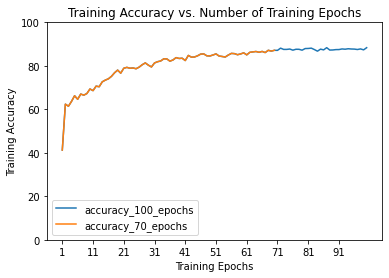

In [42]:
# accuracy on 100 epochs
acc_list = [41.27648835604686, 62.38594578919693, 61.431933042433315, 63.65238155684716, 66.24623267839004, 64.61978502215472, 67.01767772745792, 66.52130876804586, 67.27904174393196, 69.35545182964505, 68.60380358217192, 70.65988735685762, 70.40220146232635, 72.64754975903284, 73.44117901105321, 74.04281799037891, 75.18137131079304, 76.81506275705392, 78.04720525019225, 76.62631398312679, 78.90545930967409, 79.29773976279505, 78.90278332656145, 79.02218946950124, 78.67063826485278, 79.41192680727416, 80.51150051743718, 81.34856328853637, 80.3128394573011, 79.49648845985702, 81.32823370490472, 81.90747852405863, 82.2362370321683, 83.22367431820423, 83.19788707828508, 82.160319004913, 82.69752797814758, 83.78238379941787, 83.3938617869502, 83.49783631932192, 82.4377412144981, 84.79187778983749, 83.98948717134051, 84.0718590891266, 84.6199159654323, 85.3944318382787, 85.50164575014698, 84.63131305139692, 84.53686143660323, 84.9847501664276, 85.4969054061543, 84.50605898143546, 84.3051722798138, 84.05936109240145, 84.97891388821581, 85.7252748376863, 85.61498153400262, 85.1215537134892, 85.47774874492912, 85.97311076219549, 85.05472913501238, 86.22592975285355, 86.4160343092698, 86.59965730773986, 86.23304190688573, 86.62994484332475, 86.11116055656024, 87.15004818191962, 86.78340938174938, 87.15601770660176, 87.12701505388532, 88.14319271984421, 87.55493665464684, 87.56272432879804, 87.73221677683222, 87.21551705921318, 87.62741607822404, 87.61005116066224, 87.2062764066737, 87.95252428352495, 87.99768213439181, 88.14209972625025, 87.4867594076394, 86.75077106898604, 87.68713555952279, 87.3415314438038, 88.36000236694896, 87.26398257733368, 87.30344575750794, 87.4706709240687, 87.49139616642753, 87.77269588642602, 87.65017251800728, 87.86298790367617, 87.74661477469947, 87.70549439351677, 87.5121548987188, 87.78640869029402, 87.35590975665798, 88.34516550622169]
# accuracy on 70 epochs
acc_list_70 = [41.27648835604686, 62.38594578919693, 61.431933042433315, 63.65238155684716, 66.24623267839004, 64.61978502215472, 67.01767772745792, 66.52130876804586, 67.27904174393196, 69.35545182964505, 68.60380358217192, 70.65988735685762, 70.40220146232635, 72.64754975903284, 73.44117901105321, 74.04281799037891, 75.18137131079304, 76.81506275705392, 78.04720525019225, 76.62631398312679, 78.90545930967409, 79.29773976279505, 78.90278332656145, 79.02218946950124, 78.67063826485278, 79.41192680727416, 80.51150051743718, 81.34856328853637, 80.3128394573011, 79.49648845985702, 81.32823370490472, 81.90747852405863, 82.2362370321683, 83.22367431820423, 83.19788707828508, 82.160319004913, 82.69752797814758, 83.78238379941787, 83.3938617869502, 83.49783631932192, 82.4377412144981, 84.79187778983749, 83.98948717134051, 84.0718590891266, 84.6199159654323, 85.3944318382787, 85.50164575014698, 84.63131305139692, 84.53686143660323, 84.9847501664276, 85.4969054061543, 84.50605898143546, 84.3051722798138, 84.05936109240145, 84.97891388821581, 85.7252748376863, 85.61498153400262, 85.1215537134892, 85.47774874492912, 85.97311076219549, 85.05472913501238, 86.22592975285355, 86.4160343092698, 86.59965730773986, 86.23304190688573, 86.62994484332475, 86.11116055656024, 87.15004818191962, 86.78340938174938, 87.15601770660176]
plt.close()
# plot acccuracy
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,epochs+1),acc_list,label="accuracy_100_epochs")
plt.plot(range(1,70+1),acc_list_70,label="accuracy_70_epochs")
plt.ylim((0,100.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()

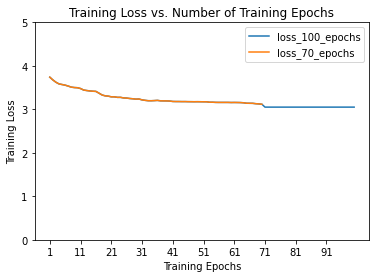

In [43]:
# loss on 100 epochs
loss_list = [3.739976757249122, 3.6759780446288572, 3.6228611157453754, 3.584424921684342, 3.57016366780164, 3.5558267191382242, 3.534532097983408, 3.510327455743218, 3.5009809533355223, 3.4969047339149646, 3.4782048303116735, 3.4438611156264063, 3.4326089536640008, 3.4231463682723478, 3.416548250186851, 3.4125956798223425, 3.3719136422308877, 3.330183819266152, 3.310611918658558, 3.3037548722395713, 3.2876998322830353, 3.287447780190819, 3.275676827555451, 3.2757857685357754, 3.2623886663908928, 3.259084630060484, 3.2491585728628056, 3.242886199797663, 3.234524550812105, 3.23771057618216, 3.2177238090177416, 3.2068882257166043, 3.1984384549215767, 3.1978711885225843, 3.2011082508194613, 3.20589757829125, 3.1958012211490683, 3.194570457431632, 3.193804332667913, 3.190595260808166, 3.18102510834124, 3.1794381189634144, 3.179319934825782, 3.1780607436504402, 3.178268298296861, 3.1763842801452884, 3.1757423124562805, 3.174906609763562, 3.1756849979730677, 3.1747987323123925, 3.173803165405089, 3.1733177336648675, 3.163581253297372, 3.16346928243426, 3.159932219046702, 3.1590442796588185, 3.159184462107883, 3.159194261735114, 3.1590768441827723, 3.156971197013164, 3.15797443744882, 3.15701491827936, 3.155622679462855, 3.1509447035415312, 3.1402814249157665, 3.1393382841912314, 3.1382171028336767, 3.129702519123223, 3.1249943446345494, 3.11653772590146, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407]
# loss on 70 epochs
loss_list_70_epochs = [3.739976757249122, 3.6759780446288572, 3.6228611157453754, 3.584424921684342, 3.57016366780164, 3.5558267191382242, 3.534532097983408, 3.510327455743218, 3.5009809533355223, 3.4969047339149646, 3.4782048303116735, 3.4438611156264063, 3.4326089536640008, 3.4231463682723478, 3.416548250186851, 3.4125956798223425, 3.3719136422308877, 3.330183819266152, 3.310611918658558, 3.3037548722395713, 3.2876998322830353, 3.287447780190819, 3.275676827555451, 3.2757857685357754, 3.2623886663908928, 3.259084630060484, 3.2491585728628056, 3.242886199797663, 3.234524550812105, 3.23771057618216, 3.2177238090177416, 3.2068882257166043, 3.1984384549215767, 3.1978711885225843, 3.2011082508194613, 3.20589757829125, 3.1958012211490683, 3.194570457431632, 3.193804332667913, 3.190595260808166, 3.18102510834124, 3.1794381189634144, 3.179319934825782, 3.1780607436504402, 3.178268298296861, 3.1763842801452884, 3.1757423124562805, 3.174906609763562, 3.1756849979730677, 3.1747987323123925, 3.173803165405089, 3.1733177336648675, 3.163581253297372, 3.16346928243426, 3.159932219046702, 3.1590442796588185, 3.159184462107883, 3.159194261735114, 3.1590768441827723, 3.156971197013164, 3.15797443744882, 3.15701491827936, 3.155622679462855, 3.1509447035415312, 3.1402814249157665, 3.1393382841912314, 3.1382171028336767, 3.129702519123223, 3.1249943446345494, 3.11653772590146]
plt.close()
# plot loss
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,epochs+1),loss_list,label="loss_100_epochs")
plt.plot(range(1,70+1),loss_list_70_epochs,label="loss_70_epochs")
plt.ylim((0,5.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()

# Decode Segmentation

In [ ]:
# Define the helper function
# https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/
def decode_segmap(image, nc=49):
  label_colors = np.array([(0, 0, 0),  # 0=background
                # 1='Frontal Pole', 2='Insular Cortex', 3='Superior Frontal Gyrus', 4='Middle Frontal Gyrus', 5='Inferior Frontal Gyrus, pars triangularis'
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6='Inferior Frontal Gyrus, pars opercularis', 7='Precentral Gyrus', 8='Temporal Pole', 9='Superior Temporal Gyrus, anterior division', 10='Superior Temporal Gyrus, posterior division'
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11='Middle Temporal Gyrus, anterior division' table, 12='Middle Temporal Gyrus, posterior division', 13='Middle Temporal Gyrus, temporooccipital part', 14='Inferior Temporal Gyrus, anterior division', 15='Inferior Temporal Gyrus, posterior division'
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16='Inferior Temporal Gyrus, temporooccipital part', 17='Postcentral Gyrus', 18='Superior Parietal Lobule', 19='Supramarginal Gyrus, anterior division', 20='Supramarginal Gyrus, posterior division'
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128),
                # 21='Angular Gyrus', 22='Lateral Occipital Cortex, superior division', 23='Lateral Occipital Cortex, inferior division', 24='Intracalcarine Cortex', 25='Frontal Medial Cortex'
               (192, 192, 192), (192, 102, 0), (192, 0, 102), (102, 0, 192), (102, 192, 0),
               # 26='Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 27='Subcallosal Cortex', 28='Paracingulate Gyrus', 29='Cingulate Gyrus, anterior division', 30='Cingulate Gyrus, posterior division'
               (204, 128, 128), (128, 204, 128), (64, 204, 0), (192, 0, 204), (64, 128, 204),
               # 31='Precuneous Cortex' table, 32='Cuneal Cortex', 33='Frontal Orbital Cortex', 34='Parahippocampal Gyrus, anterior division', 35='Parahippocampal Gyrus, posterior division'
               (105, 128, 0), (64, 105, 128), (192, 0, 105), (64, 105, 128), (192, 128, 105),
               # 36='Lingual Gyrus', 37='Temporal Fusiform Cortex, anterior division', 38='Temporal Fusiform Cortex, posterior division', 39='Temporal Occipital Fusiform Cortex', 40='Occipital Fusiform Gyrus'
               (75, 64, 0), (128, 64, 75), (75, 192, 0), (128, 192, 75), (75, 64, 128),
               # 41='Frontal Operculum Cortex', 42='Central Opercular Cortex', 43='Parietal Operculum Cortex', 44='Planum Polare', 45="Heschl's Gyrus (includes H1 and H2)"
               (128, 210, 0), (210, 128, 0), (128, 128, 210), (0, 210, 128), (128, 210, 128),
               # 46='Planum Temporale', 47='Supracalcarine Cortex', 48='Occipital Pole'
               (145, 128, 128), (128, 128, 145), (64, 145, 0)])
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)

  return rgb


In [ ]:
# how to use

rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()


NameError: ignored

# Validation

In [10]:
# close all the plot windows 
plt.close('all')

In [11]:
def validate(val_dataloader, model, OUTPUT_DIR):
    model.eval()


    total_test = 0
    correct_test = 0
    loss_final = 0
    acc_final = 0

    # directory for saving the prediction images
    pred_dir = os.path.join(saved_model_dir, "pred_images") #_70_epoch
    if not os.path.exists(pred_dir):
      os.makedirs(pred_dir)

    colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n_classes)]

    #print('size of each prediction batch:', len(val_dataloader))
    for batch_idx, batch in enumerate(val_dataloader):
        #print("batch inde ==== ", batch_idx)
        input_tensor = torch.autograd.Variable(batch['image'])
        target_tensor = torch.autograd.Variable(batch['mask'])
        subj_id = torch.autograd.Variable(batch['subj_id'])
        subject_id = subj_id.numpy()[0]
        #print('^^^^^^^^^^^^^^^^^  subject ids ************', subj_id.numpy()[0], type(subj_id.numpy()[0]))
        #print('shape pf the image and mask in the dataset: ', input_tensor.shape, target_tensor.shape)
        #break
        # if CUDA:
        #     input_tensor = input_tensor.cuda(GPU_ID)
        #     target_tensor = target_tensor.cuda(GPU_ID)

        predicted_tensor, softmaxed_tensor = model(input_tensor)
        #print('predicted tensor shape and target tensor shape are:  ', predicted_tensor.shape, target_tensor.shape)
        target_tensor_resized = torch.argmax(target_tensor, dim=1)
        #print('predicted tensor shape and target tensor:  ', predicted_tensor, target_tensor.shape)
        loss = criterion(predicted_tensor, target_tensor_resized)

        loss_final += loss.item()
        #print('loss:', loss)

        # ACCURACY
        _, pred = torch.max(softmaxed_tensor, 1)
        total_test += target_tensor_resized.nelement()
        #print('total test == ', total_test)
        #print('pred == ', pred[1,50:100, 50:100])
        #print('target_tensor_resized.data == ', target_tensor_resized.data[1,50:100, 50:100])
        acc_item = pred.eq(target_tensor_resized.data).sum().item()
        #print('acc_item == ', acc_item)
        correct_test += acc_item
        test_accuracy = 100 * correct_test / total_test
        #print('test_accuracy == ', test_accuracy)
        acc_final += test_accuracy
        
        
        for idx, predicted_mask in enumerate(softmaxed_tensor):

            #print('loss for image {}, in batch {} is {}:',idx, batch_idx, loss)


            target_mask = target_tensor[idx]
            input_image = input_tensor[idx]
            #print('idx idx idx idx ixd idx x shape of the image and mask in idx idx idx idx ixd idx x: ', input_image.shape, target_mask.shape)

            #print('target_mask and input_image type:   -------- ', type(target_mask), type(input_image))

            fig = plt.figure()


            # convert input data from torch tensor to numpy array
            # image resized from (3,224,224) to (224,224,3) for plotting
            image_input = input_image.permute(1, 2, 0).numpy()[:,:,:]
            



            # convert target data from torch tensor to numpy array
            #target_mx = target_mask.permute(1, 2, 0).numpy()
            #target_mx = torchvision.utils.make_grid(target_mx.unsqueeze(1)).numpy()
            #target_mx = target_mx.reshape((target_mx.shape[0], target_mx.shape[1], 1))
            #target_mx = target_mask.cpu().data.numpy().squeeze()


            # mask resized from (49,224,224) to (224,224) for plotting each pixel to be a class number from 0-49
            # now target_numpy is a torch tensor with size (224,224)
            target_numpy = torch.argmax(target_mask, dim=0)
            #print(target_numpy[0:10, 0:10])
            # convert the torch tensor to numy array of size 50176
            target_mx = target_numpy.numpy()   #.squeeze(), dim=0).detach().cpu().numpy().       .squeeze().detach.cpu()
            # ADD A 3RD DIMENTION (BY COPYING THE FIRST IMAGE 2 MORE TIMES) TO BE ABLE TO PLOT THE MASK 
            target_mx = np.repeat(target_mx[:, :, np.newaxis], 3, axis=2).astype(np.uint8)
            #print('target mask size and type. !!!!!!!!!!!', type(target_mx), target_mx.shape, target_mx[50:100,50:100,1])

            

            # convert predicted data from torch tensor to numpy array
            predicted_mx = torch.argmax(predicted_mask.squeeze(), dim=0).detach().cpu().numpy()
            predicted_mx = np.repeat(predicted_mx[:, :, np.newaxis], 3, axis=2).astype(np.uint8)
            #print('PREDICTED TYPE AND SHAPE:   ====== ',type(predicted_mx), predicted_mx.shape, predicted_mx[50:100,50:100,1])
            #$predicted_mx = predicted_mask.cpu().data
            #$predicted_mx = torchvision.utils.make_grid(predicted_mx.unsqueeze(1)).numpy()
            #predicted_mx = predicted_mx.argmax(axis=0)


            plotImages(image_input, target_mx, predicted_mx, 49, batch_idx, idx, OUTPUT_DIR, pred_dir, colors, subject_id, validation=True)
        
        
        plt.close('all')


    # after all batches print the total loss and accuracy and plot them
    
    val_epoch_loss = loss_final/len(val_dataloader)  
    val_epoch_acc = acc_final/len(val_dataloader) 
    print('loss total ==', val_epoch_loss)
    print('accuracy total ==', val_epoch_acc)
    return val_epoch_loss, val_epoch_acc



In [17]:
import os
import matplotlib.image as pltimage
# constants
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = 49
NUM_BACHES = 2
NUM_EPOCHS = 10

LR = 0.001

INPUT_WIDTH = 224
INPUT_HEIGHT = 224

OUTPUT_WIDTH = 256
OUTPUT_HEIGHT = 256

NUM_WORKERS = 4



#data_root = args.data_root
#val_path = os.path.join(data_root, args.val_path)
val_img_dir = val_images_path
val_mask_dir = val_segs_path

SAVED_MODEL_PATH = os.path.join(saved_model_dir, "model_epoch_69.pth")

# create output directory
OUTPUT_DIR = os.path.join(saved_model_dir, "predictions_70_3")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#instances
lb = LoadBatches()
    
print('image directory: ', val_img_dir)
print('mask directory: ', val_mask_dir)

# get the list of images and labels
val_images_paths, val_labels_paths = LoadBatches.imageSegmentationGenerator(lb, val_img_dir, val_mask_dir, NUM_BACHES, NUM_OUTPUT_CHANNELS, input_height, input_width, OUTPUT_HEIGHT, OUTPUT_WIDTH)






#print(val_images_paths, val_labels_paths)
# for im, seg in zip(val_images, val_labels):
  
#   print(im.shape, seg.shape)#








val_dataset = Dataset(val_images_paths, val_labels_paths)


# create data loader
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                          batch_size=NUM_BACHES,
                          shuffle=True,   
                          num_workers= NUM_WORKERS)

print(NUM_BACHES)







    # if CUDA:
    #     model = SegNet(input_channels=NUM_INPUT_CHANNELS,
    #                    output_channels=NUM_OUTPUT_CHANNELS).cuda(GPU_ID)

    #     class_weights = 1.0/val_dataset.get_class_probability().cuda(GPU_ID)
    #     criterion = torch.nn.CrossEntropyLoss(weight=class_weights).cuda(GPU_ID)
    # else:

# load model
model =  VGG_net_youtube_new(in_channels=NUM_INPUT_CHANNELS, out_channels=NUM_OUTPUT_CHANNELS) 

#class_weights = 1.0/val_dataset.get_class_probability()
criterion = torch.nn.CrossEntropyLoss() #weight=class_weights


model.load_state_dict(torch.load(SAVED_MODEL_PATH))




image directory:  /content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/images/
mask directory:  /content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/mask/
2


<All keys matched successfully>

In [18]:
# CALL VALIDATION FUNCTION ON 70th EPOCH (the segmentaiton results)
val_loss, val_acc = validate(val_dataloader, model, OUTPUT_DIR)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
loss total == 3.7659430024779845
accuracy total == 75.84500456295875


In [26]:
# validation Accuracy and loss for 70 epochs
# FOR THE SAME IMAGES AND LABELS IN VALID FORLDER, RUN 69 DIFFERENT MODELS TO TRACKING THE ACCURACY AND LOSS
loss_arr = []
acc_arr = []
for i in range(0,70):
    # load model
  SAVED_MODEL_PATH = os.path.join(saved_model_dir, "model_epoch_{}.pth".format(i))
  model_i =  VGG_net_youtube_new(in_channels=NUM_INPUT_CHANNELS, out_channels=NUM_OUTPUT_CHANNELS) 
  criterion = torch.nn.CrossEntropyLoss() 
  model_i.load_state_dict(torch.load(SAVED_MODEL_PATH))
  # VALIDATE MODEL
  loss, acc = validate(val_dataloader, model_i, OUTPUT_DIR)
  print('epoch_{}_loss == {}'.format(i, loss))
  print('epoch_{}_accuracy == {}'.format(i, acc))

  loss_arr.append(loss)
  acc_arr.append(acc)



print('loss_arr == ', loss_arr)
print('acc_arr == ', acc_arr)




loss total == 4.664805510514219
accuracy total == 64.93506202894093
epoch_0_loss == 4.664805510514219
epoch_0_accuracy == 64.93506202894093
loss total == 4.307852337897663
accuracy total == 56.08991514412677
epoch_1_loss == 4.307852337897663
epoch_1_accuracy == 56.08991514412677
loss total == 5.132734678160976
accuracy total == 62.3918805725029
epoch_2_loss == 5.132734678160976
epoch_2_accuracy == 62.3918805725029
loss total == 5.26405238433623
accuracy total == 64.90623232590754
epoch_3_loss == 5.26405238433623
epoch_3_accuracy == 64.90623232590754
loss total == 5.984090855423833
accuracy total == 64.90720557364176
epoch_4_loss == 5.984090855423833
epoch_4_accuracy == 64.90720557364176
loss total == 5.8359418771636316
accuracy total == 61.19603003578694
epoch_5_loss == 5.8359418771636316
epoch_5_accuracy == 61.19603003578694
loss total == 6.889155846246531
accuracy total == 65.17713561142922
epoch_6_loss == 6.889155846246531
epoch_6_accuracy == 65.17713561142922
loss total == 7.109611

## Plotting Accuracy and Loss for Validation Over Epochs

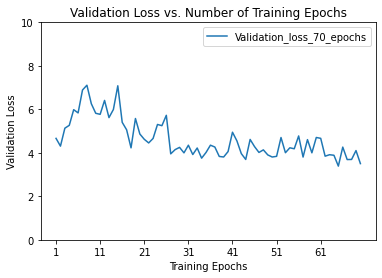

In [30]:
# accuracy on 70 epochs
val_loss_list_70 = [4.664805510514219, 4.307852337897663, 5.132734678160976, 5.26405238433623, 5.984090855423833, 5.8359418771636316, 6.889155846246531, 7.109611670735856, 6.256845292910723, 5.818175836348198, 5.770463653013739, 6.410162069428135, 5.619395850409924, 5.992142976169855, 7.08312906345851, 5.402436514975319, 5.058849581530397, 4.228623616863304, 5.577871230286612, 4.864918970725905, 4.622981585247416, 4.4544378015357005, 4.661464551804771, 5.304359711391825, 5.248533604850231, 5.725142304326447, 3.9534154534339905, 4.147698195047782, 4.250299888597408, 3.99855448158694, 4.349947894123239, 3.9211546149052365, 4.222139434075691, 3.7543379093559697, 4.015746405426885, 4.351557629209169, 4.266799285378255, 3.8331541612114703, 3.808592871880867, 4.058417726570452, 4.947525323276788, 4.550958225424861, 3.9636424695941765, 3.6949865263952337, 4.615570531764501, 4.28560874999409, 4.017715266053106, 4.135773411938842, 3.904325478513476, 3.807324269288023, 3.838362090184655, 4.704036053637384, 4.004674878758444, 4.231264789339522, 4.1864909638821235, 4.7758533022773095, 3.805234519528671, 4.60727518041369, 4.000565073020022, 4.705633400191723, 4.666319029431947, 3.845516945274783, 3.912545902628294, 3.88800546988635, 3.3886948059981976, 4.263234262735072, 3.690604869748505, 3.6956435811351724, 4.103452573359852, 3.5039917113075796]
plt.close()
# plot acccuracy
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,70+1),val_loss_list_70,label="Validation_loss_70_epochs")
plt.ylim((0,10.))
plt.xticks(np.arange(1, 70+1, 10.0))
plt.legend()
plt.show()

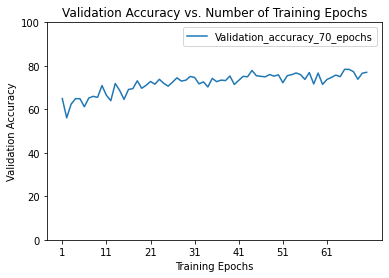

In [15]:
# accuracy on 70 epochs
val_acc_list_70 = [64.93506202894093, 56.08991514412677, 62.3918805725029, 64.90623232590754, 64.90720557364176, 61.19603003578694, 65.17713561142922, 65.9738730048942, 65.5174168842467, 70.92563739305291, 66.4535314218075, 63.996945588276134, 71.86050437590579, 68.73275442826086, 64.57103284682672, 69.13406902155064, 69.53113672153381, 73.1328174114338, 69.67943797585806, 71.04905208935504, 72.80011023145951, 71.56101023901591, 73.81209655798257, 71.95314324274753, 70.66239974468401, 72.53765167294395, 74.48476304534019, 72.99972503445386, 73.40356062446975, 75.12100495266067, 74.64461286068763, 71.70236008015586, 72.62797976163534, 70.29069998680454, 74.23202982333815, 72.73714963334513, 73.43378441390624, 73.23187952993123, 75.32609312139375, 71.46133224550152, 73.32903992083676, 75.16628704976804, 74.97407779491546, 77.88163359519608, 75.45545864338484, 75.18962656927718, 74.9447714545183, 76.00981110363512, 75.27456728543989, 75.86867147641995, 72.24113092853963, 75.46628265419588, 75.94351839749388, 76.71795966805702, 75.96942987357872, 73.77091088890522, 76.91381767831909, 71.6624806716112, 76.69624826350238, 71.47629064911963, 73.72387643360358, 74.66917768784755, 75.74912283777743, 75.03936097736613, 78.40073691034866, 78.39002296594558, 77.34887563358365, 73.83201407886608, 76.60770165218408, 77.02753664515402]
plt.close()
# plot acccuracy
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,70+1),val_acc_list_70,label="Validation_accuracy_70_epochs")
plt.ylim((0,100.))
plt.xticks(np.arange(1, 70+1, 10.0))
plt.legend()
plt.show()

In [ ]:
val_loss_list_70 = [4.664805510514219, 4.307852337897663, 5.132734678160976, 5.26405238433623, 5.984090855423833, 5.8359418771636316, 6.889155846246531, 7.109611670735856, 6.256845292910723, 5.818175836348198, 5.770463653013739, 6.410162069428135, 5.619395850409924, 5.992142976169855, 7.08312906345851, 5.402436514975319, 5.058849581530397, 4.228623616863304, 5.577871230286612, 4.864918970725905, 4.622981585247416, 4.4544378015357005, 4.661464551804771, 5.304359711391825, 5.248533604850231, 5.725142304326447, 3.9534154534339905, 4.147698195047782, 4.250299888597408, 3.99855448158694, 4.349947894123239, 3.9211546149052365, 4.222139434075691, 3.7543379093559697, 4.015746405426885, 4.351557629209169, 4.266799285378255, 3.8331541612114703, 3.808592871880867, 4.058417726570452, 4.947525323276788, 4.550958225424861, 3.9636424695941765, 3.6949865263952337, 4.615570531764501, 4.28560874999409, 4.017715266053106, 4.135773411938842, 3.904325478513476, 3.807324269288023, 3.838362090184655, 4.704036053637384, 4.004674878758444, 4.231264789339522, 4.1864909638821235, 4.7758533022773095, 3.805234519528671, 4.60727518041369, 4.000565073020022, 4.705633400191723, 4.666319029431947, 3.845516945274783, 3.912545902628294, 3.88800546988635, 3.3886948059981976, 4.263234262735072, 3.690604869748505, 3.6956435811351724, 4.103452573359852, 3.5039917113075796]
average_loss = sum(val_loss_list_70)/len(val_loss_list_70)
average_loss


val_acc_list_70 = [64.93506202894093, 56.08991514412677, 62.3918805725029, 64.90623232590754, 64.90720557364176, 61.19603003578694, 65.17713561142922, 65.9738730048942, 65.5174168842467, 70.92563739305291, 66.4535314218075, 63.996945588276134, 71.86050437590579, 68.73275442826086, 64.57103284682672, 69.13406902155064, 69.53113672153381, 73.1328174114338, 69.67943797585806, 71.04905208935504, 72.80011023145951, 71.56101023901591, 73.81209655798257, 71.95314324274753, 70.66239974468401, 72.53765167294395, 74.48476304534019, 72.99972503445386, 73.40356062446975, 75.12100495266067, 74.64461286068763, 71.70236008015586, 72.62797976163534, 70.29069998680454, 74.23202982333815, 72.73714963334513, 73.43378441390624, 73.23187952993123, 75.32609312139375, 71.46133224550152, 73.32903992083676, 75.16628704976804, 74.97407779491546, 77.88163359519608, 75.45545864338484, 75.18962656927718, 74.9447714545183, 76.00981110363512, 75.27456728543989, 75.86867147641995, 72.24113092853963, 75.46628265419588, 75.94351839749388, 76.71795966805702, 75.96942987357872, 73.77091088890522, 76.91381767831909, 71.6624806716112, 76.69624826350238, 71.47629064911963, 73.72387643360358, 74.66917768784755, 75.74912283777743, 75.03936097736613, 78.40073691034866, 78.39002296594558, 77.34887563358365, 73.83201407886608, 76.60770165218408, 77.02753664515402]
average_accuracy = sum(val_acc_list_70)/len(val_acc_list_70)
average_accuracy

In [16]:
def plotImages(image, seg, pred, n_classes, batch_idx, idx, OUTPUT_DIR, pred_dir, colors, file_name, validation=False):
  # print(np.unique(seg))
  # print(np.unique(pred))

  # print(seg.shape)
  # print(pred.shape)

  print('PLOT IMAGE')


  seg_img = np.zeros_like(seg)
  pred_img = np.zeros_like(pred)

  #colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n_classes)]
  
  # r_seg = np.zeros_like(seg).astype(np.uint8)
  # g_seg = np.zeros_like(seg).astype(np.uint8)
  # b_seg = np.zeros_like(seg).astype(np.uint8)



  # r_pred = np.zeros_like(pred).astype(np.uint8)
  # g_pred = np.zeros_like(pred).astype(np.uint8)
  # b_pred = np.zeros_like(pred).astype(np.uint8)



  for c in range(n_classes):

    seg_img[:, :, 0] += ((seg[:, :, 0] == c) * (colors[c][0])).astype('uint8')
    seg_img[:, :, 1] += ((seg[:, :, 0] == c) * (colors[c][1])).astype('uint8')
    seg_img[:, :, 2] += ((seg[:, :, 0] == c) * (colors[c][2])).astype('uint8')


    pred_img[:, :, 0] += ((pred[:, :, 0] == c) * (colors[c][0])).astype('uint8')
    pred_img[:, :, 1] += ((pred[:, :, 0] == c) * (colors[c][1])).astype('uint8')
    pred_img[:, :, 2] += ((pred[:, :, 0] == c) * (colors[c][2])).astype('uint8')
    
  
  # for l in range(0, n_classes):
  #   indx = seg == l
  #   r_seg[indx] = colors[l][0]
  #   g_seg[indx] = colors[l][1]
  #   b_seg[indx] = colors[l][2]
  #   rgb_seg = np.stack([r_seg, g_seg, b_seg], axis=2)
    

  # for l in range(0, n_classes):
  #   indx = pred == l
  #   r_pred[indx] = colors[l][0]
  #   g_pred[indx] = colors[l][1]
  #   b_pred[indx] = colors[l][2]
  #   rgb_pred = np.stack([r_pred, g_pred, b_pred], axis=2)
    
   
  plt.figure(figsize=(10, 10))
  fig = plt.figure()

  a = fig.add_subplot(1,3,1)    
  plt.imshow(image)
  a.set_title("Original image") 

  a = fig.add_subplot(1,3,2)
  plt.imshow(seg_img)
  a.set_title("mask image")


  a = fig.add_subplot(1,3,3)
  plt.imshow(pred_img)
  a.set_title("predicted image")

  if validation == True:
    # save predictions
    plt.imsave(os.path.join(pred_dir, "prediction_{}_{}.png".format(batch_idx, file_name)), pred_img) #, cmap="gray"
    # save plots 
    out_dir = os.path.join(OUTPUT_DIR, "prediction_{}_{}.png".format(batch_idx, file_name))
    fig.savefig(out_dir)

    plt.close(fig)


In [ ]:
for im_path, seg_path in zip(val_images_paths, val_labels_paths):
  print(im_path, seg_path)
  image = pltimage.imread(im_path)
  seg = pltimage.imread(seg_path)

  print('image size ===== ', image.shape)
  print('seg size ===== ', seg.shape)
  


  plt.figure(figsize=(10, 10))
  fig = plt.figure()

  a = fig.add_subplot(1,3,1)    
  plt.imshow(image)
  a.set_title("Original image") 

  a = fig.add_subplot(1,3,2)
  plt.imshow(seg)
  a.set_title("mask image")

  break

NameError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
def imageSegmentationPlotting_1(images_path, segs_path, n_classes):
    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = glob.glob(images_path + "*.jpg") + glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg")
    images.sort()
    segmentations = glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg")
    segmentations.sort()

    print(type(images))

    colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n_classes)]
    assert len(images) == len(segmentations)

    for im_fn, seg_fn in zip(images, segmentations):
        assert (im_fn.split('/')[-1] == seg_fn.split('/')[-1])

        img = cv2.imread(im_fn)
        seg = cv2.imread(seg_fn)
        print(img.shape, seg.shape)


        print('mask r value:', seg[40:50,40:50,0])
        print('mask g value:', seg[40:50,40:50,1])
        print('mask b value:', seg[40:50,40:50,2])

        print('seg uniques:', np.unique(seg))

        seg_img = np.zeros_like(seg)

        for c in range(n_classes):
            seg_img[:, :, 0] += ((seg[:, :, 0] == c) * (colors[c][0])).astype('uint8')
            seg_img[:, :, 1] += ((seg[:, :, 0] == c) * (colors[c][1])).astype('uint8')
            seg_img[:, :, 2] += ((seg[:, :, 0] == c) * (colors[c][2])).astype('uint8')


        plt.figure(figsize=(10, 10))
        fig = plt.figure()
  
        a = fig.add_subplot(1,3,1)    
        plt.imshow(img)
        a.set_title("Original val image") 

        a = fig.add_subplot(1,3,2)
        plt.imshow(seg_img)
        a.set_title("colored & masked image")


        a = fig.add_subplot(1,3,3)
        plt.imshow(seg)
        a.set_title("mask val image")


        #plt.close()
        # cv2_imshow(img)
        # cv2_imshow(seg_img)
        # cv2_imshow(seg)
        # cv2.waitKey()


<class 'list'>
(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask g value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask b value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
seg uniques: [ 0  8 14 15 34 37 38]
(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask g value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask b value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
seg uniques: [ 0  1  8  9 11 12 14 15 16 23 25 27 33 34 35 36 37 38 39 40 44 48]
(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f05a5139268> (for post_execute):


KeyboardInterrupt: ignored

<Figure size 720x720 with 0 Axes>

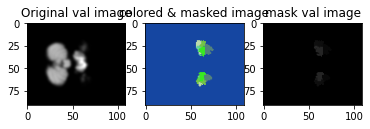

<Figure size 720x720 with 0 Axes>

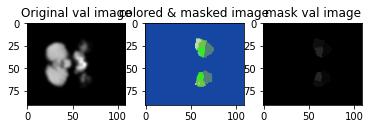

<Figure size 720x720 with 0 Axes>

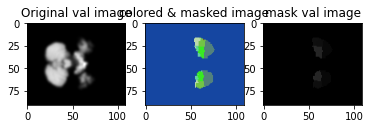

<Figure size 720x720 with 0 Axes>

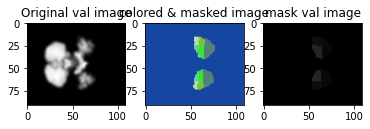

<Figure size 720x720 with 0 Axes>

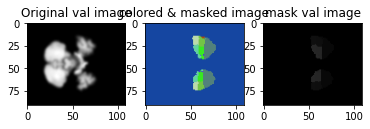

<Figure size 720x720 with 0 Axes>

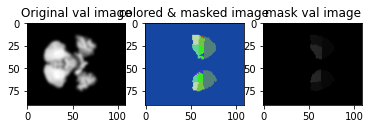

<Figure size 720x720 with 0 Axes>

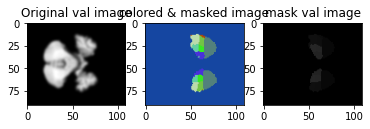

<Figure size 720x720 with 0 Axes>

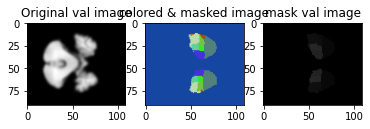

<Figure size 720x720 with 0 Axes>

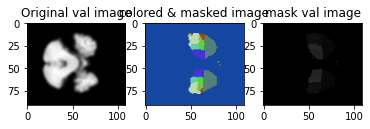

<Figure size 720x720 with 0 Axes>

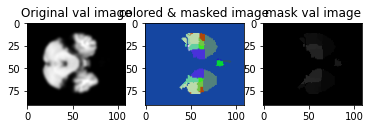

<Figure size 720x720 with 0 Axes>

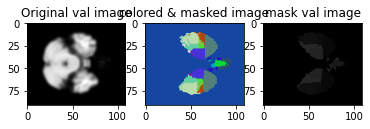

<Figure size 720x720 with 0 Axes>

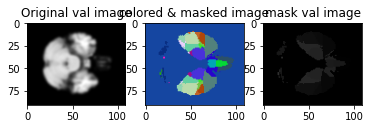

<Figure size 720x720 with 0 Axes>

Error in callback <function flush_figures at 0x7f05a27717b8> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
imageSegmentationPlotting_1(val_images_path, val_segs_path, 49)

In [ ]:
print(val_images_path)

/content/drive/My Drive/ADNI_1/ADNI/T1/validation/images/


<class 'list'>
(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask g value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask b value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
seg uniques: [ 0  8 14 15 34 37 38]
(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask g value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
mask b value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
seg uniques: [ 0  1  8  9 11 12 13 14 15 16 23 25 27 33 34 35 36 37 38 39 40 48]
(91, 109, 3) (91, 109, 3)
mask r value: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f05a5139268> (for post_execute):


KeyboardInterrupt: ignored

<Figure size 720x720 with 0 Axes>

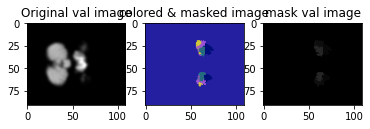

<Figure size 720x720 with 0 Axes>

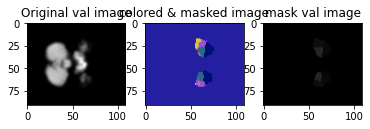

<Figure size 720x720 with 0 Axes>

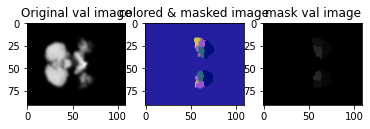

<Figure size 720x720 with 0 Axes>

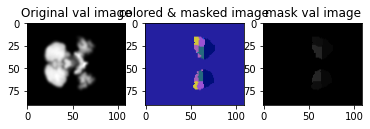

<Figure size 720x720 with 0 Axes>

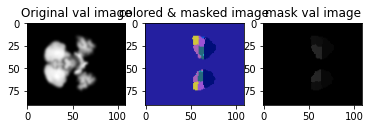

<Figure size 720x720 with 0 Axes>

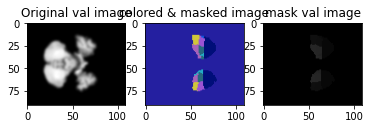

<Figure size 720x720 with 0 Axes>

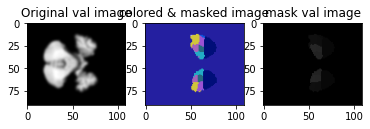

<Figure size 720x720 with 0 Axes>

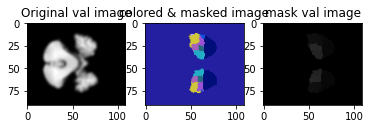

<Figure size 720x720 with 0 Axes>

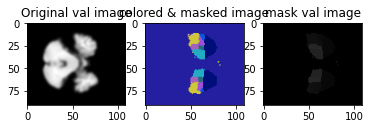

<Figure size 720x720 with 0 Axes>

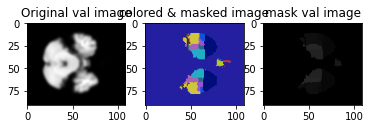

<Figure size 720x720 with 0 Axes>

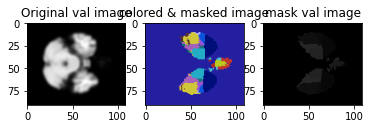

<Figure size 720x720 with 0 Axes>

Error in callback <function flush_figures at 0x7f05a27717b8> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
imageSegmentationPlotting_1(val_images_path, val_segs_path, 49)

In [ ]:
imageSegmentationPlotting(val_images_path, val_segs_path, 49)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from matplotlib import cm
import numpy as np

# test inputs and masks plotting
for im, seg in zip(val_images, val_labels):
  #assert (im.split('/')[-1].split(".")[0] == seg.split('/')[-1].split(".")[0])
  print(im)
  # image_w = cv2.imread(im, 1)
  # mask_w = cv2.imread(seg)

  print('shape of the image and mask coming from the generator: ', im.shape, seg.shape)

  im = np.transpose(im, (1,2,0))
  #seg = np.transpose(seg, (1,2,0))
  

  # create colormap
  N = 49 # You define this here
  colours = cm.get_cmap('viridis', N)  # Change the string from 'viridis' to whatever you want from the above link
  cmap = colours(np.linspace(0, 1, N))  # Obtain RGB colour map
  cmap[0,-1] = 0  # Set alpha for label 0 to be 0
  cmap[1:,-1] = 0.3  # Set the other alphas for the labels to be 0.3
  

  print('cmap:', cmap)

  output = cmap[seg.flatten()]

  R, C = seg.shape[:2]
  output = output.reshape((R, C, -1))


  plt.figure(figsize=(10, 10))

  plt.subplot(241)
  plt.axis('off')
  plt.imshow(im, cmap='jet')
  plt.title("Original val image") 

  plt.subplot(245)
  plt.axis('off')
  plt.imshow(output)
  plt.title("mask val image")   

  break

[[[-103.939 -103.939 -103.939 ... -103.939 -103.939 -103.939]
  [-103.939 -103.939 -103.939 ... -103.939 -103.939 -103.939]
  [-103.939 -103.939 -103.939 ... -103.939 -103.939 -103.939]
  ...
  [-103.939 -103.939 -103.939 ... -103.939 -103.939 -103.939]
  [-103.939 -103.939 -103.939 ... -103.939 -103.939 -103.939]
  [-103.939 -103.939 -103.939 ... -103.939 -103.939 -103.939]]

 [[-116.779 -116.779 -116.779 ... -116.779 -116.779 -116.779]
  [-116.779 -116.779 -116.779 ... -116.779 -116.779 -116.779]
  [-116.779 -116.779 -116.779 ... -116.779 -116.779 -116.779]
  ...
  [-116.779 -116.779 -116.779 ... -116.779 -116.779 -116.779]
  [-116.779 -116.779 -116.779 ... -116.779 -116.779 -116.779]
  [-116.779 -116.779 -116.779 ... -116.779 -116.779 -116.779]]

 [[-123.68  -123.68  -123.68  ... -123.68  -123.68  -123.68 ]
  [-123.68  -123.68  -123.68  ... -123.68  -123.68  -123.68 ]
  [-123.68  -123.68  -123.68  ... -123.68  -123.68  -123.68 ]
  ...
  [-123.68  -123.68  -123.68  ... -123.68  -123.

IndexError: ignored

# AD/CN Prediction